I downloaded the MovieLens latest small datasets from the link below. 
https://grouplens.org/datasets/movielens/

In [425]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
import sklearn.utils
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans



In [426]:
# load data into pandas dataframe
ratings = pd.read_csv('../data/raw/ml-latest-small/ratings.csv')
tags = pd.read_csv('../data/raw/ml-latest-small/tags.csv')
print(ratings)
print(tags)

        userId  movieId  rating   timestamp
0            1        1     4.0   964982703
1            1        3     4.0   964981247
2            1        6     4.0   964982224
3            1       47     5.0   964983815
4            1       50     5.0   964982931
...        ...      ...     ...         ...
100831     610   166534     4.0  1493848402
100832     610   168248     5.0  1493850091
100833     610   168250     5.0  1494273047
100834     610   168252     5.0  1493846352
100835     610   170875     3.0  1493846415

[100836 rows x 4 columns]
      userId  movieId               tag   timestamp
0          2    60756             funny  1445714994
1          2    60756   Highly quotable  1445714996
2          2    60756      will ferrell  1445714992
3          2    89774      Boxing story  1445715207
4          2    89774               MMA  1445715200
...      ...      ...               ...         ...
3678     606     7382         for katie  1171234019
3679     606     7936        

In [427]:
# merged on userId and movieId since these are the common columns
movieData = pd.merge(ratings,tags,on=['userId','movieId'], how = 'outer')
# deleted timestamps because most data points had different timestamp making it hard to merge without nan's
movieData = movieData.drop(['timestamp_y', 'timestamp_x'], axis=1)

# dropped all nan for use in clustering algs later on
movieData = movieData.dropna()
# changed all tags to lowercase for better encoding
movieData['tag'] = movieData['tag'].str.lower()

Maybe there is a correlation between length of tas and ratings. The scale for the ratings may not really be 0-5. I will look at the distribution to determine the practical ratings range.

In [428]:
# python list comprehension without a condition
tagLength = [len(x) for x in movieData['tag']]
movieData['tagLength'] = tagLength

# encode the tags for when I run clustering algs since tags are strings
encodeTag = preprocessing.LabelEncoder()
encodeTag.fit(movieData.iloc[:, 2].values)
Tag = encodeTag.transform(movieData.iloc[:, 2].values)
movieData['tag'] = Tag
# reindex for removed rows starting with 1
movieData.index = np.arange(1, len(movieData)+1)


movieData

,userId,movieId,rating,tag,tagLength
1,2,60756,5.0,9,5
2,2,60756,5.0,9,15
3,2,60756,5.0,9,12
4,2,89774,5.0,9,12
5,2,89774,5.0,9,3
...,...,...,...,...,...
3472,606,6107,4.0,7,12
3473,606,7382,4.5,8,9
3474,610,3265,5.0,9,6
3475,610,3265,5.0,9,16


            userId        movieId       rating          tag    tagLength
count  3476.000000    3476.000000  3476.000000  3476.000000  3476.000000
mean    429.785386   28009.502301     4.016830     7.033659    10.011507
std     161.552990   44138.125029     0.856925     1.713851     4.743357
min       2.000000       1.000000     0.500000     0.000000     2.000000
25%     424.000000    1261.500000     3.500000     6.000000     6.000000
50%     474.000000    4492.000000     4.000000     7.000000     9.000000
75%     523.250000   45499.000000     5.000000     9.000000    12.000000
max     610.000000  193565.000000     5.000000     9.000000    85.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc1ad98e970>]],
      dtype=object)

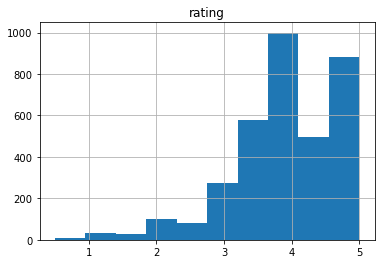

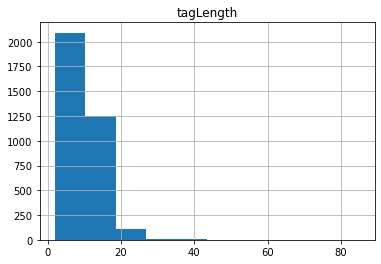

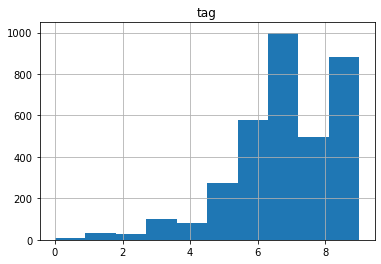

In [429]:
print(movieData.describe())
movieData.hist(column='rating')
movieData.hist(column='tagLength')
movieData.hist(column='tag')

Ratings stats show that 75% of users rate between 3.5 and 5. This indicates that the rating scale is really between 3.5 and 5. Ratings distribution is skewed to the right.
Only 25% of tags are longer than 12 character (outliers). Tag length is left skewed.

In [430]:
correlation = movieData.corr()
print(correlation)
greaterThan12 = movieData[movieData['tagLength'] >12]
print(greaterThan12.corr())
movieDataFeatures = movieData[['rating','tag']]
movieDataFeatures

             userId   movieId    rating       tag  tagLength
userId     1.000000 -0.333151  0.043002  0.043002  -0.052648
movieId   -0.333151  1.000000 -0.011801 -0.011801   0.054428
rating     0.043002 -0.011801  1.000000  1.000000   0.064803
tag        0.043002 -0.011801  1.000000  1.000000   0.064803
tagLength -0.052648  0.054428  0.064803  0.064803   1.000000
             userId   movieId    rating       tag  tagLength
userId     1.000000 -0.322729  0.061005  0.061005  -0.024438
movieId   -0.322729  1.000000 -0.122486 -0.122486  -0.021678
rating     0.061005 -0.122486  1.000000  1.000000   0.004281
tag        0.061005 -0.122486  1.000000  1.000000   0.004281
tagLength -0.024438 -0.021678  0.004281  0.004281   1.000000


,rating,tag
1,5.0,9
2,5.0,9
3,5.0,9
4,5.0,9
5,5.0,9
...,...,...
3472,4.0,7
3473,4.5,8
3474,5.0,9
3475,5.0,9


Low correlation between rating and tag length longer than 12. Low correlation between columns in general. Below I perform kmeans with 3 different n values

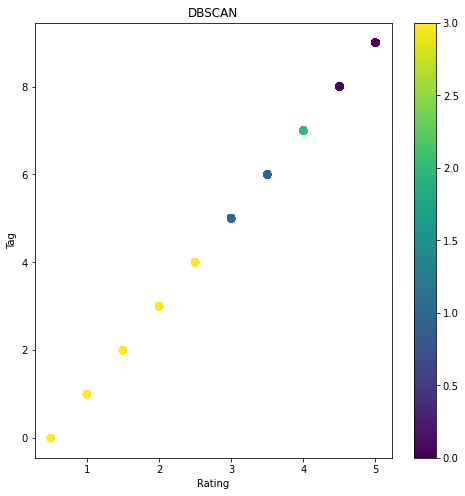

In [431]:
km = KMeans(n_clusters=4).fit(movieDataFeatures)
#cent = kmeans.cluster_centers_

fig = plt.figure(figsize=(8,8)); ax = fig.add_subplot(111)
scatter = ax.scatter(movieDataFeatures['rating'],movieDataFeatures['tag'], c=km.labels_,s=50)
ax.set_title('DBSCAN')
ax.set_xlabel('Rating'); ax.set_ylabel('Tag')
plt.colorbar(scatter); 
plt.show()

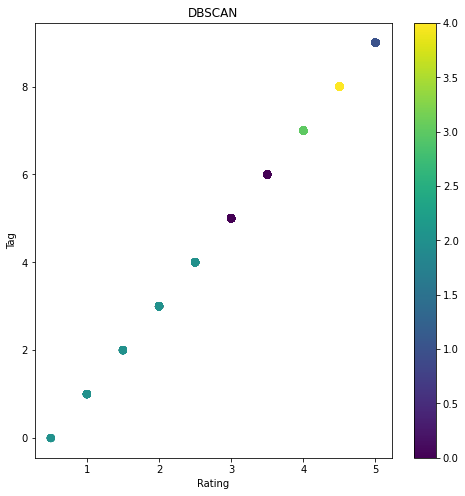

In [432]:
km = KMeans(n_clusters=5).fit(movieDataFeatures)
#cent = kmeans.cluster_centers_

fig = plt.figure(figsize=(8,8)); ax = fig.add_subplot(111)
scatter = ax.scatter(movieDataFeatures['rating'],movieDataFeatures['tag'], c=km.labels_,s=50)
ax.set_title('DBSCAN')
ax.set_xlabel('Rating'); ax.set_ylabel('Tag')
plt.colorbar(scatter); 
plt.show()

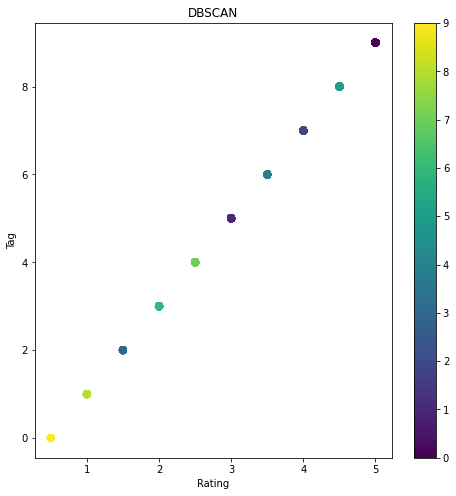

In [433]:
km = KMeans(n_clusters=10).fit(movieDataFeatures)



fig = plt.figure(figsize=(8,8)); ax = fig.add_subplot(111)
scatter = ax.scatter(movieDataFeatures['rating'],movieDataFeatures['tag'], c=km.labels_,s=50)
ax.set_title('DBSCAN')
ax.set_xlabel('Rating'); ax.set_ylabel('Tag')
plt.colorbar(scatter); 
plt.show()

Below I run DBSCAN.

In [434]:
model = DBSCAN(eps=0.25, min_samples = 10).fit(movieDataFeatures)
clusters = pd.DataFrame(model.fit_predict(movieDataFeatures))
movieData['Clusters'] = clusters
print(clusters[0])

0       0
1       0
2       0
3       0
4       0
       ..
3471    2
3472    3
3473    0
3474    0
3475    0
Name: 0, Length: 3476, dtype: int64


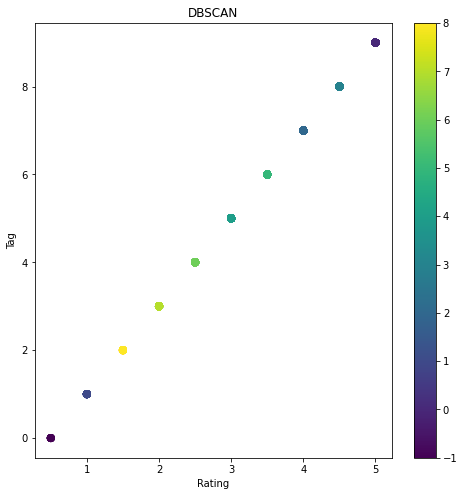

In [435]:
fig = plt.figure(figsize=(8,8)); ax = fig.add_subplot(111)
scatter = ax.scatter(movieDataFeatures['rating'],movieDataFeatures['tag'], c=clusters[0],s=50)
ax.set_title('DBSCAN')
ax.set_xlabel('Rating'); ax.set_ylabel('Tag')
plt.colorbar(scatter); 
plt.show()